In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import glob
import os
import cv2
from patchify import patchify
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# Define U-Net
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])
    model.summary()

    return model

In [5]:
patch_size = 128

In [6]:
# Build U-Net
# REQUIREMENT: Model summary must be visible
model = simple_unet_model(patch_size, patch_size, 3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

## Training the Y24 dataset: 

In [7]:
train_image_datagen = ImageDataGenerator(rescale=1./255)
train_mask_datagen = ImageDataGenerator(rescale=1./255)
patch_size = 128

train_image_generator = train_image_datagen.flow_from_directory(
    'C:/Users/emilp/Documents/Buas_Y2/Block_B/data_sets/dataset_patches_Y24_3/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='rgb',
    seed=42)

train_mask_generator = train_mask_datagen.flow_from_directory(
    'C:/Users/emilp/Documents/Buas_Y2/Block_B/data_sets/dataset_patches_Y24_3/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

Found 12271 images belonging to 1 classes.
Found 12271 images belonging to 1 classes.


In [7]:
val_image_datagen = ImageDataGenerator(rescale=1./255)
val_mask_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = train_image_datagen.flow_from_directory(
    'C:/Users/emilp/Documents/Buas_Y2/Block_B/data_sets/dataset_patches_Y24_3/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='rgb',
    seed=42)

val_mask_generator = train_mask_datagen.flow_from_directory(
    'C:/Users/emilp/Documents/Buas_Y2/Block_B/data_sets/dataset_patches_Y24_3/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

val_generator = zip(val_image_generator, val_mask_generator)

Found 2333 images belonging to 1 classes.
Found 2333 images belonging to 1 classes.


In [7]:
# EarlyStopping()
from keras.callbacks import EarlyStopping

cb = EarlyStopping(monitor='val_loss',
                   patience=3,
                   restore_best_weights='True',
                   mode='min')

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=30,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb]
)

Epoch 1/30
767/767 [==============================] - 34s 36ms/step - loss: 0.0993 - accuracy: 0.9474 - f1: 0.6541 - val_loss: 0.0565 - val_accuracy: 0.9508 - val_f1: 0.8479
Epoch 2/30
767/767 [==============================] - 25s 32ms/step - loss: 0.0547 - accuracy: 0.9561 - f1: 0.8352 - val_loss: 0.0464 - val_accuracy: 0.9560 - val_f1: 0.8633
Epoch 3/30
767/767 [==============================] - 25s 32ms/step - loss: 0.0478 - accuracy: 0.9575 - f1: 0.8517 - val_loss: 0.0431 - val_accuracy: 0.9577 - val_f1: 0.8681
Epoch 4/30
767/767 [==============================] - 25s 32ms/step - loss: 0.0433 - accuracy: 0.9584 - f1: 0.8665 - val_loss: 0.0398 - val_accuracy: 0.9580 - val_f1: 0.8803
Epoch 5/30
767/767 [==============================] - 25s 32ms/step - loss: 0.0415 - accuracy: 0.9587 - f1: 0.8713 - val_loss: 0.0414 - val_accuracy: 0.9545 - val_f1: 0.8862
Epoch 6/30
767/767 [==============================] - 25s 32ms/step - loss: 0.0410 - accuracy: 0.9587 - f1: 0.8735 - val_loss: 0.0

In [11]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.031241493299603462
Best validation f1: 0.907482922077179


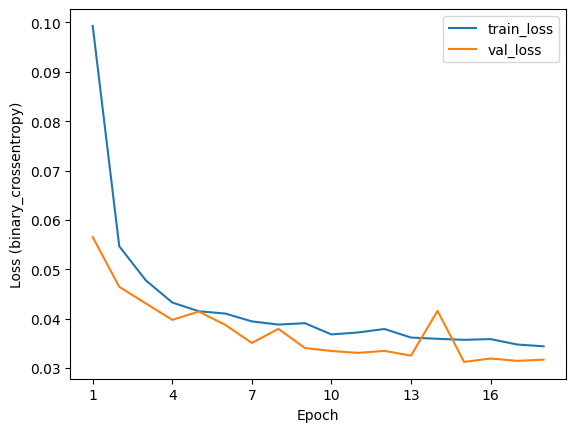

In [12]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

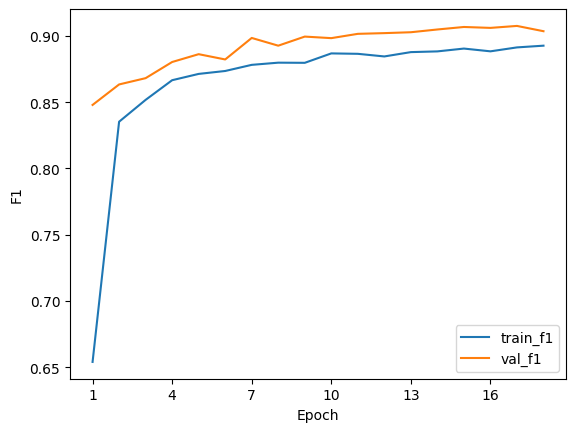

In [ ]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

## Training the final model with both Y23 and Y24 datasets:

In [8]:
train_image_datagen = ImageDataGenerator(rescale=1./255)
train_mask_datagen = ImageDataGenerator(rescale=1./255)
patch_size = 128

train_image_generator = train_image_datagen.flow_from_directory(
    'C:/Users/emilp/Documents/Buas_Y2/Block_B/data_sets/dataset_patches_Y23&24/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='rgb',
    seed=42)

train_mask_generator = train_mask_datagen.flow_from_directory(
    'C:/Users/emilp/Documents/Buas_Y2/Block_B/data_sets/dataset_patches_Y23&24/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

Found 20909 images belonging to 1 classes.
Found 20909 images belonging to 1 classes.


In [9]:
val_image_datagen = ImageDataGenerator(rescale=1./255)
val_mask_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = train_image_datagen.flow_from_directory(
    'C:/Users/emilp/Documents/Buas_Y2/Block_B/data_sets/dataset_patches_Y23&24/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='rgb',
    seed=42)

val_mask_generator = train_mask_datagen.flow_from_directory(
    'C:/Users/emilp/Documents/Buas_Y2/Block_B/data_sets/dataset_patches_Y23&24/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

val_generator = zip(val_image_generator, val_mask_generator)

Found 4434 images belonging to 1 classes.
Found 4434 images belonging to 1 classes.


In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=30,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb]
)

Epoch 1/30
1307/1307 [==============================] - 53s 40ms/step - loss: 0.0451 - accuracy: 0.9528 - f1: 0.8694 - val_loss: 0.0413 - val_accuracy: 0.9555 - val_f1: 0.8916
Epoch 2/30
1307/1307 [==============================] - 49s 37ms/step - loss: 0.0432 - accuracy: 0.9532 - f1: 0.8736 - val_loss: 0.0425 - val_accuracy: 0.9552 - val_f1: 0.8928
Epoch 3/30
1307/1307 [==============================] - 49s 38ms/step - loss: 0.0418 - accuracy: 0.9534 - f1: 0.8768 - val_loss: 0.0405 - val_accuracy: 0.9545 - val_f1: 0.8969
Epoch 4/30
1307/1307 [==============================] - 49s 38ms/step - loss: 0.0413 - accuracy: 0.9535 - f1: 0.8780 - val_loss: 0.0404 - val_accuracy: 0.9551 - val_f1: 0.8964
Epoch 5/30
1307/1307 [==============================] - 49s 37ms/step - loss: 0.0415 - accuracy: 0.9535 - f1: 0.8770 - val_loss: 0.0403 - val_accuracy: 0.9558 - val_f1: 0.8950
Epoch 6/30
1307/1307 [==============================] - 49s 38ms/step - loss: 0.0413 - accuracy: 0.9535 - f1: 0.8779 - v

In [17]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.03958956152200699
Best validation f1: 0.8979098200798035


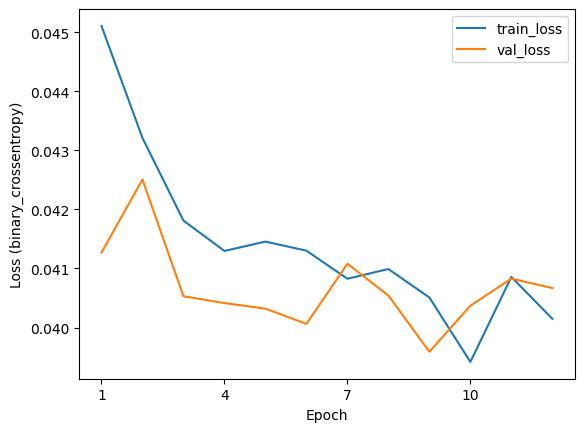

In [18]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

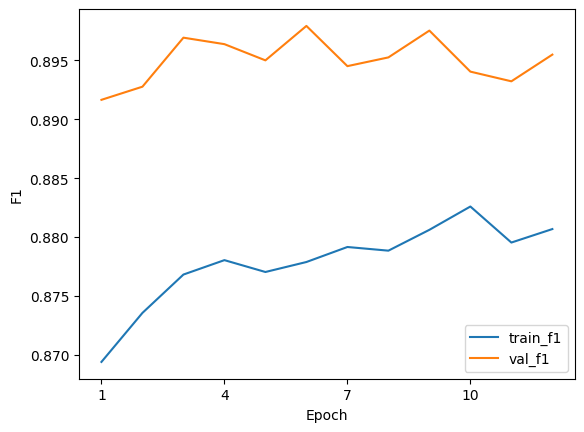

In [19]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

In [20]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
example_file_name = f'emil_2310077_unet_model_{patch_size}px.h5'
print(example_file_name)
model.save(example_file_name)

emil_2310077_unet_model_128px.h5


-----

In [10]:
train_image_datagen = ImageDataGenerator(rescale=1./255)
train_mask_datagen = ImageDataGenerator(rescale=1./255)
patch_size = 128

train_image_generator = train_image_datagen.flow_from_directory(
    r"C:\Users\emilp\Documents\Buas_Y2\Block_B\data_sets\dataset_patches\train_images",
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='rgb',
    seed=42)

train_mask_generator = train_mask_datagen.flow_from_directory(
    r"C:\Users\emilp\Documents\Buas_Y2\Block_B\data_sets\dataset_patches\train_masks",
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

Found 48668 images belonging to 1 classes.
Found 48668 images belonging to 1 classes.


In [11]:
val_image_datagen = ImageDataGenerator(rescale=1./255)
val_mask_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = train_image_datagen.flow_from_directory(
    r"C:\Users\emilp\Documents\Buas_Y2\Block_B\data_sets\dataset_patches\val_images",
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='rgb',
    seed=42)

val_mask_generator = train_mask_datagen.flow_from_directory(
    r"C:\Users\emilp\Documents\Buas_Y2\Block_B\data_sets\dataset_patches\val_images",
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

val_generator = zip(val_image_generator, val_mask_generator)

Found 12167 images belonging to 1 classes.
Found 12167 images belonging to 1 classes.


In [62]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
example_file_name = f'emil_23100111_unet_model_{patch_size}px.h5'
print(example_file_name)
model.save(example_file_name)

emil_23100111_unet_model_256px.h5


#### I trained various models but this one gave the best prediction results as its using patches with 256 patch size.